<a href="https://colab.research.google.com/github/hwangsae91/project_so/blob/master/exploration/221007/%5BExp_07%5D20221007.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# google colab전용
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# exploration 7번째 과제
@ 황한용(3기/쏘카)

## 라이브러리 선언

In [2]:
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import glob # 폴더 안의 파일전체 리스트를 불러오는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 
import math # 기본적인 수식계산 라이브러리
import tensorflow as tf
from tensorflow import keras

## 상수선언

In [3]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/data/self" # 데이터 기본경로
SELF_PATH = DATA_PATH + "/face/*" # 셀카경로
DNN_MODEL_PATH = DATA_PATH + "/model/mmod_human_face_detector.dat"
MODEL_PATH = DATA_PATH + "/model/shape_predictor_68_face_landmarks.dat"
GTX_MODEL_PATH = DATA_PATH + "/model/shape_predictor_68_face_landmarks_GTX.dat"
FILTER_PATH = DATA_PATH + "/filter/cat-whiskers.png" # 필터경로
ANGLE_MODEL = DATA_PATH + "/model/pose_model/saved_model.pb"
STICKER_PATH = DATA_PATH + "/cat-whiskers.png"
PYRAMID_NUM = 1 # 얼굴인식을 위한 image piramid의 층수
MAX_POINT_NUM = 68 # 얼굴의 이목구비에 대한 총 좌표의 수

## 메인

### 기존의 방식과 문제점

In [4]:
img_rgb_list = [cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) for f in glob.glob(SELF_PATH)] # RGB를 원본데이터로 정의
img_show_list = [i.copy() for i in img_rgb_list] # 보여주기용 사진데이터

사진은 총 3개이며 각각 `45도 각도`, `30도 각도`, `정면` 사진으로 구성되어있다.<br>
사진의 처리 세부과정을 보기위해 이미지를 가공하는 과정 전체를 표시하였다.<br>

In [5]:
img_show_rect_list = [i.copy() for i in img_show_list] # 얼굴범위가 사각형으로 표시된 사진데이터
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환
dlib_rects_list = [detector_hog(i, PYRAMID_NUM) for i in img_rgb_list] # 얼굴 영역의 좌표
for dlib_rects, img_show in zip(dlib_rects_list, img_show_rect_list):  # 이미지와 찾은 얼굴 영역의 좌표
    for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
        cv2.rectangle(
          img_show # 표시할 사진
          ,(dlib_rect.left(),dlib_rect.top()) #시작 좌표
          , (dlib_rect.right(), dlib_rect.bottom()) #끝점 좌표
          , (0,255,0) # 선의 색
          , 10 # 선의 굵기
          , lineType=cv2.LINE_AA # 선의 종류
        ) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

- 원본사진과 비교를 하기위해 원본이미지를 복사하여 얼굴범위를 지정할 사진데이터를 생성<br>
- `PYRAMID_NUM`을 5로 설정하였을 시<br>
`colab pro`, `lms서버`에서 메모리부족 문제로 인하여 세션이 종료되었다.<br>
실험결과 최대 설정 가능한 안정적인 숫자는 3이지만 1로 설정했을때가 인식률이 가장 높다.<br>
- 사진에서 얼굴은 단 하나이기 때문에<br>
`img_show_rect_list`의 각 요소는 
리스트 형태의 사각형의 시작좌표와 끝좌표가 셋트인 단 하나만 들어가있다.<br>

In [6]:
landmark_predictor = dlib.shape_predictor(MODEL_PATH)

이미 학습이 완료된 모델을 로드한다.<br>
68개의 이목구비 위치를 점으로 표기한다.

In [7]:
landmark_points_list = [
        [
            (p.x, p.y)
            for p in landmark_predictor(img_rgb, dlib_rect).parts() # 각각의 landmark 위치정보를 (x,y) 형태로 변환 후 저장
        ]
    for dlib_rect in dlib_rects # 얼굴 영역 박스마다 68개의 이목구비 점
    for dlib_rects, img_rgb in zip(dlib_rects_list, img_rgb_list) # 이미지 마다의 이목구비 점의 위치와 이미지
]

print(f"좌표의 정상유무 : {'정상' if all([[len(face) == MAX_POINT_NUM for face in landmark_points] for landmark_points in landmark_points_list]) else '일부 누락'}")

좌표의 정상유무 : 정상


1. 한 이미지당 처리한 이목구비점을 한 리스트에 넣는다.<br>
2. 좌표처리의 이상유무는 다음의 판단으로 결정된다.
- 사진에 있는 모든 얼굴의 이목구비 좌표가 모두 있을 경우 `정상` 으로 출력<br>
- 하나라도 누락이 있을 시,  `일부 누락` 으로 출력<br>

In [8]:
img_show_p_list = [i.copy() for i in img_show_rect_list] # 얼굴범위 지정 + 68개의 이목구비 점이 표시된 사진데이터

for landmark_points, img_show in zip(landmark_points_list, img_show_p_list):  # 이미지와 찾은 얼굴 영역의 좌표
    for point in landmark_points:
        cv2.circle(
            img_show # 표시할 이미지
            , point # 점 좌표
            , 10 # 점크기
            , (0, 255, 255) # 점색
            , -1 # 원의 경계
        )

기존의 사격형으로 얼굴범위를 지정한 이미지를 복사하여 이목구비의 점을 표시

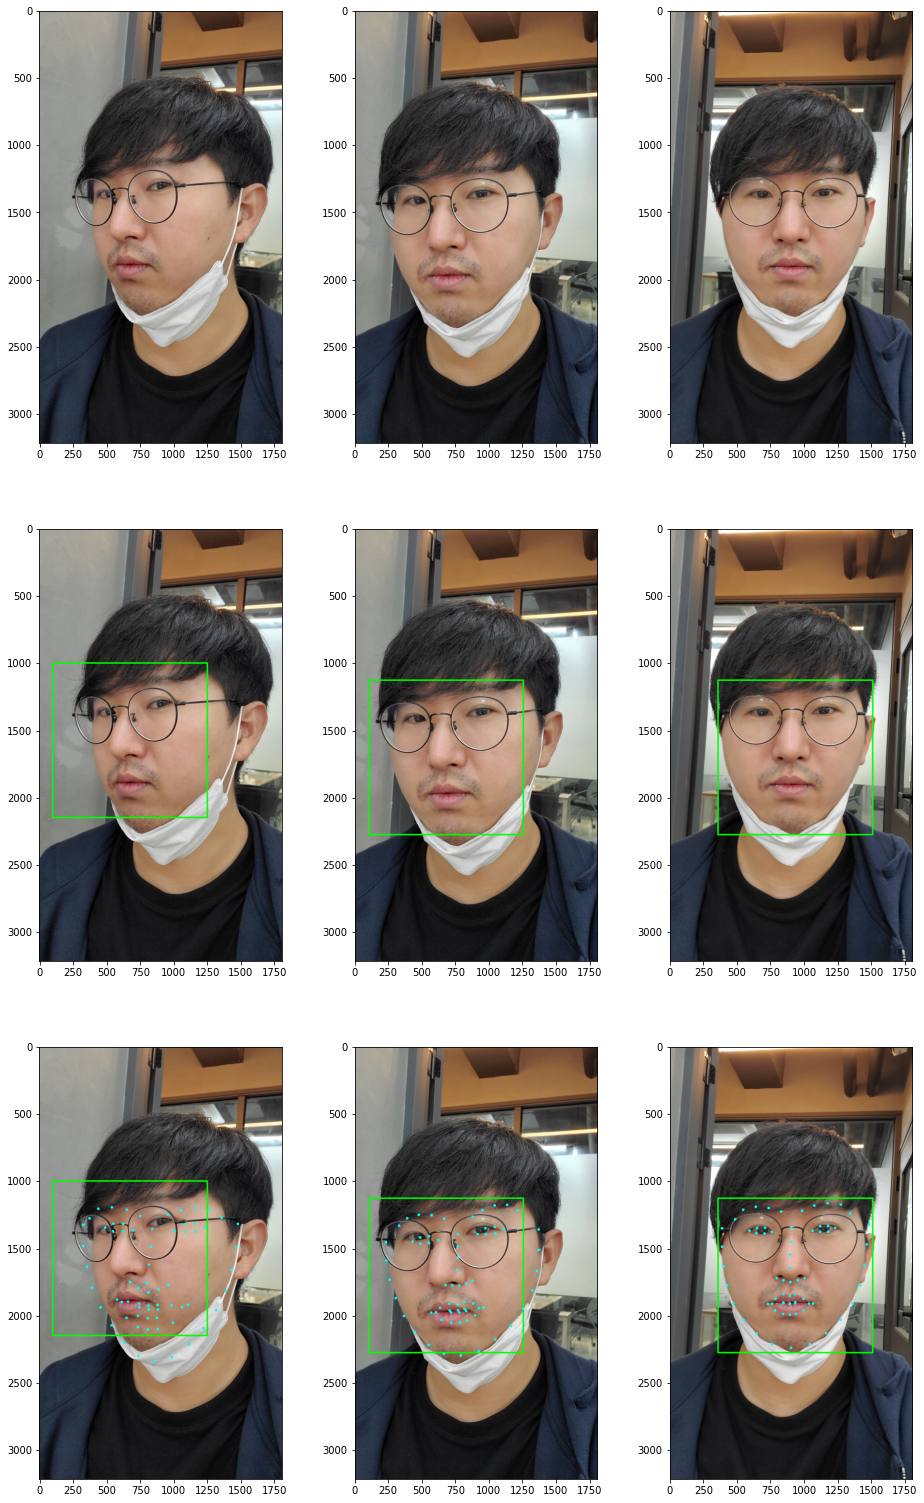

In [9]:
fig = plt.figure(figsize=(16,27))
for idx, i in enumerate(img_rgb_list + img_show_rect_list + img_show_p_list, 1):
  fig.add_subplot(330 + idx).imshow(i)
plt.show()

위에서 부터 각각
- 원본이미지
- 사각형으로 얼굴경계가 표시된 이미지
- 얼굴경계 + 이목구비가 점으로 표시된 이미지

순으로 표시하였다.<br>
<br>
위의 사진의로 아래의 정보를 얻을 수 있다.
- 정면 얼굴 인식에는 이상이 없음을 확인
- 30°각도에서 얼굴을 찍었을 시에는 실재와 이목구비가 많이 다름
- 45°각도에서 얼굴을 찍었을 시에는 30°각도보다 더 인식률이 높음
- 30°,45°각도에서 눈의 이목구비가 안경 코받침으로 인식함을 확인
- 이에 따라 코, 입,하관 등의 이목구비가 재대로 인식을 못함

### 분석

`dlib.shape_predictor` class로  구할 수 있는 값은 라이브러리에서 이미 계산한 x,y좌표밖에 없다.<br> 
즉, 각 좌표의 정확도, 유사도가 높은 다른 좌표가 전혀 존재하지 않는다.<br>
그러므로 해당 라이브러리는
- 해당 좌표가 올바르게 찍혔는가?
- 좌표가 틀렸다고 가정할 경우 차선으로 사용할 수 있는 좌표가 있는가?

에 대한 대응이 불가능하다.<br><br>
아래의 링크는 클래스에 관한 문서이다.<br>
라이브러리 설명자료<br>
- [dlib.shape_predictor(모델을 로드한 객체의 클래스)](http://dlib.net/python/index.html#dlib_pybind11.shape_predictor)<br>
- [dlib.full_object_detection(이목구비의 x,y좌표를 표시하는 객체 클래스)](http://dlib.net/python/index.html#dlib_pybind11.full_object_detection) <br>
- [point(x,y 좌표 클래스)](http://dlib.net/python/index.html#dlib_pybind11.point)

또한 추가적으로 아래의 문제가 존제한다.
- 정면으로 찍힌 사진의 기준을 판별 가능한가?
- 이목구비의 점이 근접하지 않고 전혀 다른 위치를 가르키고 있는 경우 어떻게 할것인가?

위의 논리에 따라 아래의 해결방법을 생각하였다.
- 수식을 계산하여 위치를 보정한다.
- 성능이 좋은 다른 모델을 사용한다.
- HOG와 SVM방식의 얼굴검출을 DNN방식으로 바꾼다.

1안은 현실적으로 불가능하므로 2안과 3안을 실행했다.

### 성능이 좋은 다른 모델을 사용

In [10]:
landmark_gtx_predictor = dlib.shape_predictor(GTX_MODEL_PATH)

GTX출시에 맞춰 새롭게 성능을 개선한 모델이다.

In [11]:
landmark_gtx_points_list = [
        [
            (p.x, p.y)
            for p in landmark_gtx_predictor(img_rgb, dlib_rect).parts() # 각각의 landmark 위치정보를 (x,y) 형태로 변환 후 저장
        ]
    for dlib_rect in dlib_rects # 얼굴 영역 박스마다 68개의 이목구비 점
    for dlib_rects, img_rgb in zip(dlib_rects_list, img_rgb_list) # 이미지 마다의 이목구비 점의 위치와 이미지
]

print(f"좌표의 정상유무 : {'정상' if all([[len(face) == MAX_POINT_NUM for face in landmark_points] for landmark_points in landmark_gtx_points_list]) else '일부 누락'}")

img_show_p_gtx_list = [i.copy() for i in img_show_rect_list] # 얼굴범위 지정 + 68개의 이목구비 점이 표시된 사진데이터

for landmark_points, img_show in zip(landmark_gtx_points_list, img_show_p_gtx_list):  # 이미지와 찾은 얼굴 영역의 좌표
    for point in landmark_points:
        cv2.circle(
            img_show # 표시할 이미지
            , point # 점 좌표
            , 10 # 점크기
            , (0, 255, 255) # 점색
            , -1 # 원의 경계
        )

좌표의 정상유무 : 정상


사각형으로 얼굴범위를 지정하는 과정까지는 같으므로 이목구비를 검출하는 부분만 다시 실행하였다.

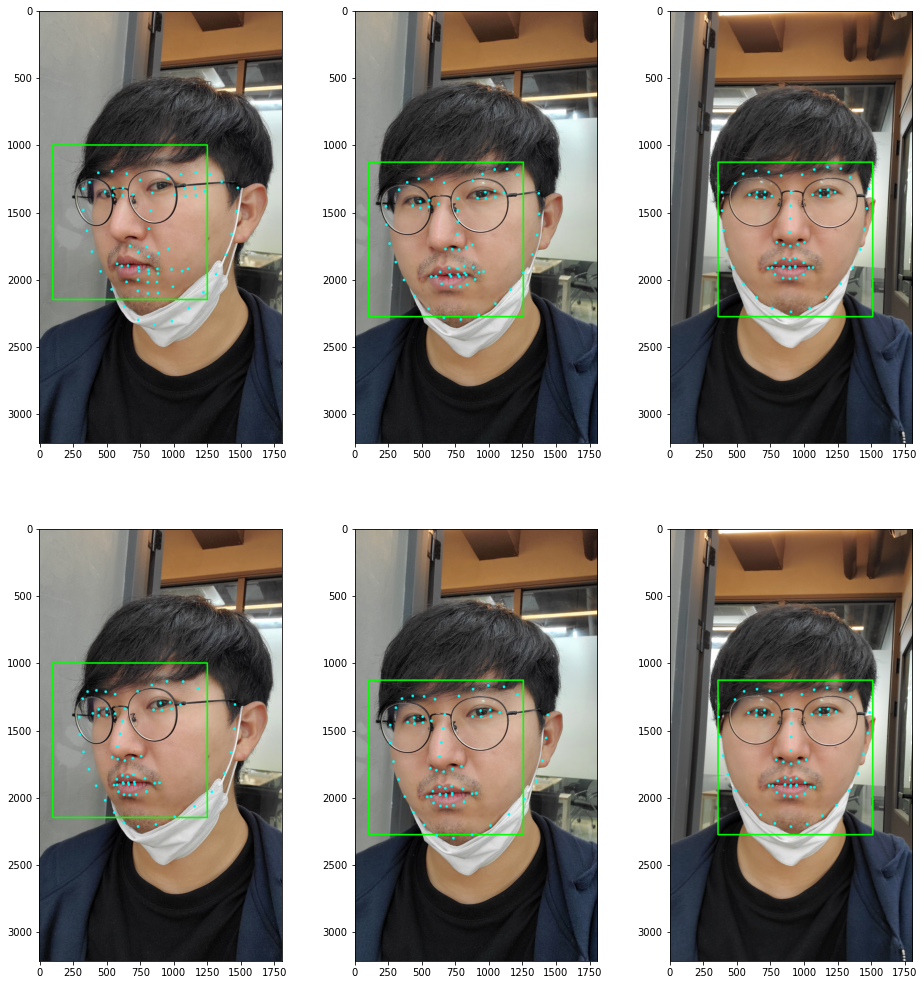

In [12]:
fig = plt.figure(figsize=(16,27))
for idx, i in enumerate(img_show_p_list + img_show_p_gtx_list, 1):
  fig.add_subplot(330 + idx).imshow(i)
plt.show()

기존의 모델보다 성능이 확실히 나아졌다.<br>
특히 눈부분의 인식률이 월등히 좋아져서 코, 입등의 윤곽을 명확히 표시하는 것을 볼 수 있다.

### 얼굴 검출을 기존의 학습된 모델을 활용 & DNN을 이용

In [13]:
img_show_dnn_list = [i.copy() for i in img_rgb_list] # DNN
detector_dnn = dlib.cnn_face_detection_model_v1(DNN_MODEL_PATH) # 기본 얼굴 감지기를 반환
dlib_cnn_rects_list = [detector_dnn(i, PYRAMID_NUM) for i in img_rgb_list] # 얼굴 영역의 좌표
for dlib_rects, img_show in zip(dlib_cnn_rects_list, img_show_dnn_list):  # 이미지와 찾은 얼굴 영역의 좌표
    for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
        rect = dlib_rect.rect
        cv2.rectangle(
          img_show # 표시할 사진
          ,(rect.left(),rect.top()) #시작 좌표
          , (rect.right(), rect.bottom()) #끝점 좌표
          , (0,255,0) # 선의 색
          , 10 # 선의 굵기
          , lineType=cv2.LINE_AA # 선의 종류
        ) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

landmark_dnn_points_list = [
        [
            (p.x, p.y)
            for p in landmark_gtx_predictor(img_rgb, dlib_rect.rect).parts() # 각각의 landmark 위치정보를 (x,y) 형태로 변환 후 저장
        ]
    for dlib_rect in dlib_rects # 얼굴 영역 박스마다 68개의 이목구비 점
    for dlib_rects, img_rgb in zip(dlib_rects_list, img_rgb_list) # 이미지 마다의 이목구비 점의 위치와 이미지
]

print(f"좌표의 정상유무 : {'정상' if all([[len(face) == MAX_POINT_NUM for face in landmark_points] for landmark_points in landmark_dnn_points_list]) else '일부 누락'}")

img_show_p_dnn_list = [i.copy() for i in img_show_dnn_list] # 얼굴범위 지정 + 68개의 이목구비 점이 표시된 사진데이터

for landmark_points, img_show in zip(landmark_dnn_points_list, img_show_p_dnn_list):  # 이미지와 찾은 얼굴 영역의 좌표
    for point in landmark_points:
        cv2.circle(
            img_show # 표시할 이미지
            , point # 점 좌표
            , 10 # 점크기
            , (0, 255, 255) # 점색
            , -1 # 원의 경계
        )

좌표의 정상유무 : 정상


얼굴범위를 지정하는 모델을 사용하였으므로 다시 처음부터 연산을 수행하여 이미지를 구하였다.

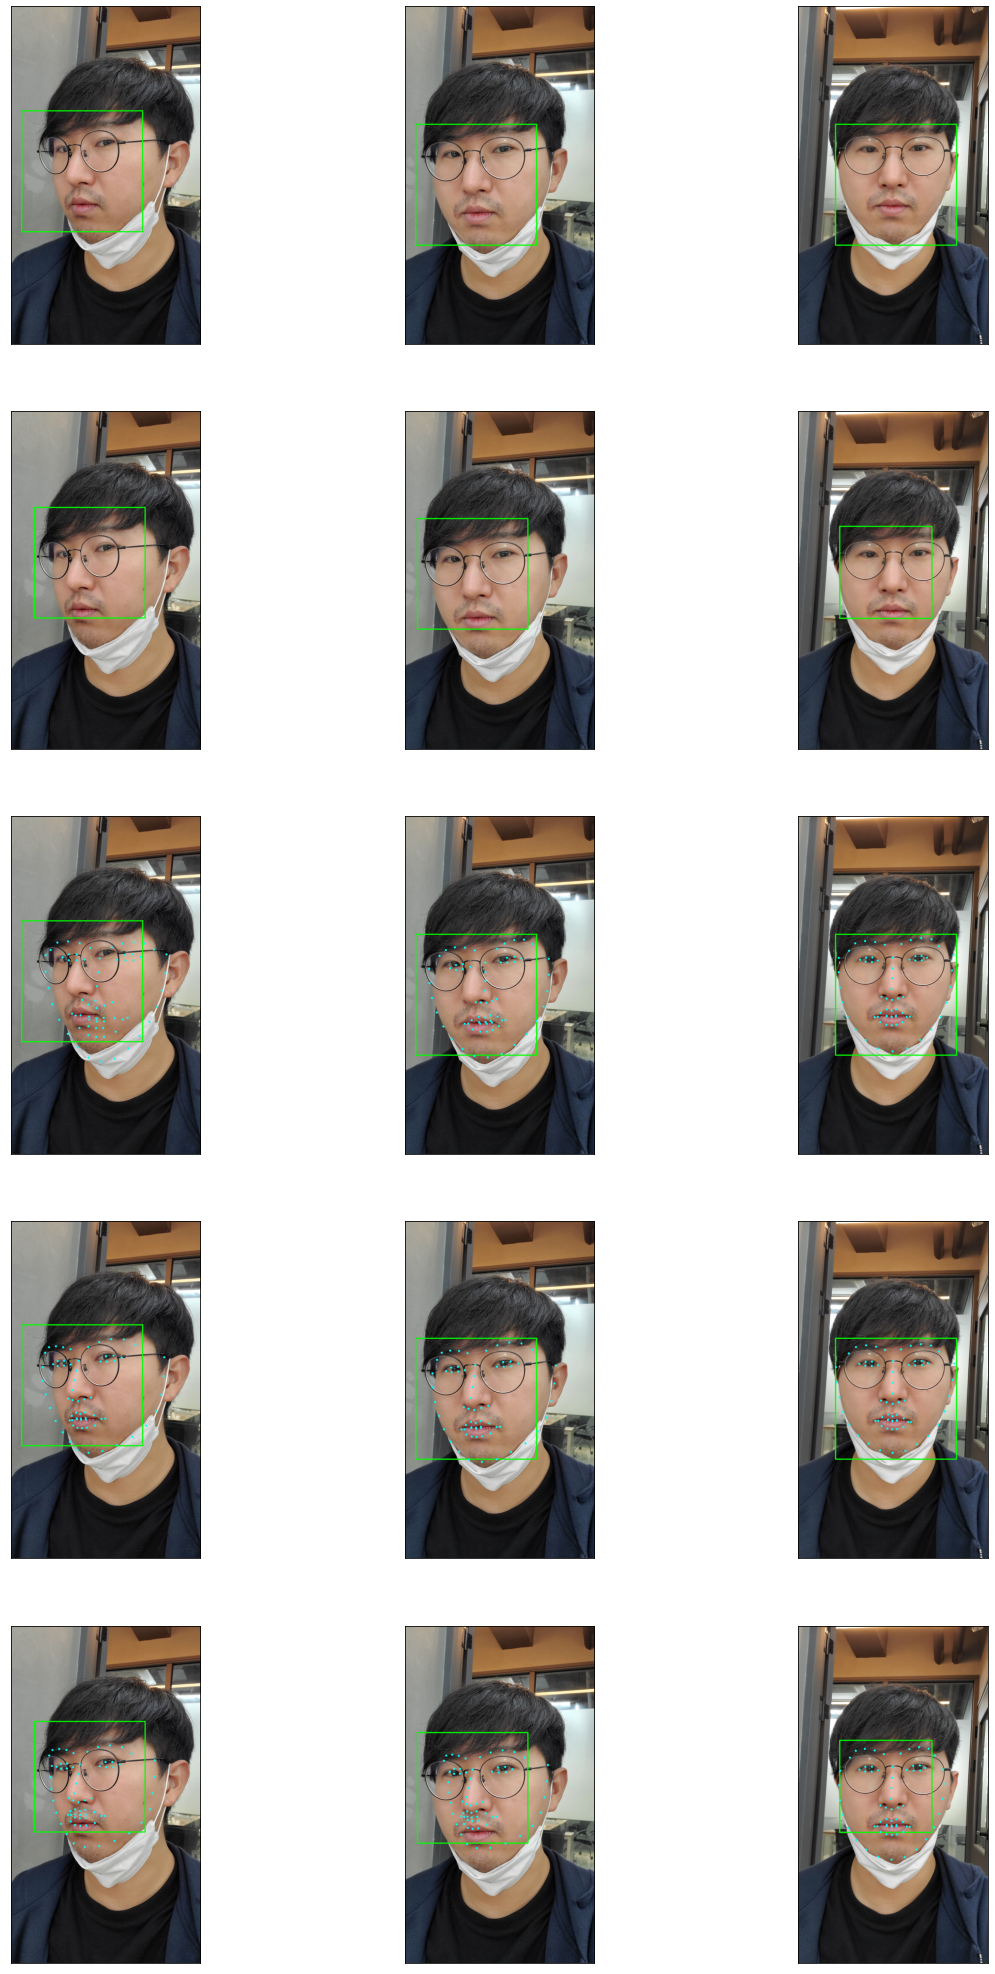

In [14]:
fig, axes = plt.subplots(nrows=5, ncols=3,figsize=(20,36))
for idx, i in enumerate(img_show_rect_list + img_show_dnn_list + img_show_p_list + img_show_p_gtx_list + img_show_p_dnn_list):
    ax = axes[idx // 3, idx % 3]
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.imshow(i)
plt.show()

위에서 부터 각각
- 기존의 얼굴검출기를 사용할 때의 이미지
- 얼굴검출기에 학습된 모델을 사용하였을 때의 이미지
- 기존의 얼굴검출 + 기존의 이목구비 모델을 사용했을 때의 이미지
- 기존의 얼굴검출 + 성능이 좋은 다른 모델을 사용하여 이목구비를 검출했을때의 이미지
- 학습된 모델을 사용한 얼굴검출기 + 성능이 좋은 다른 모델을 사용하여 이목구비를 검출했을때의 이미지

순으로 표시하였다.<br>
<br>
위의 사진의로 아래의 정보를 얻을 수 있다.
- 기존의 얼굴검출기는 3차원 회전을 반영하지 못했다.<br>
30°각도, 45°각도의 이미지를 z축으로 회전한 것이 아니라 x,y축으로만 회전한 것이 보인다.
- 학습된 모델을 사용한 얼굴검출기는 기존의 얼굴검출기보다 더 좁은 범위로 얼굴을 인식한다.
- 학습된 모델을 사용한 얼굴검출기를 이용해 구한 얼굴범위로 이목구비를 표시할 시<br>
3차원 회전은 반영되어 있지만 이목구비가 검출 정확도가 떨어진다.

위의 사진으로 나온 결론은 기존의 얼굴검출 기능을 사용하여 얼굴의 범위를 구한 후,</br>
성능이 좋은 다른 모델을 사용하여 이목구비를 검출했을때 모든 사진에 대해 대응이 가능한 것을 확인하였다.</br>
또한 이번에 적용할 고양이 수염 스티커사진은 코가 끝나는 시점인 31번이 가장 적당한 것을 확인하였다.<br>
아래는 68개의 점에 대응하는 이목구비의 위치를 그림으로 표시하였다.<br><br>
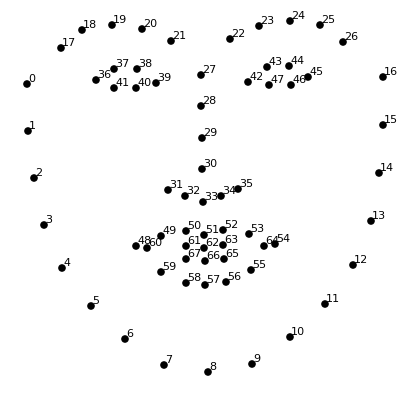
<br> 출처: aiffel exploration 7-4

### 스티커 붙이기

1151
(583, 1619)
1151
(628, 1694)
1151
(898, 1650)


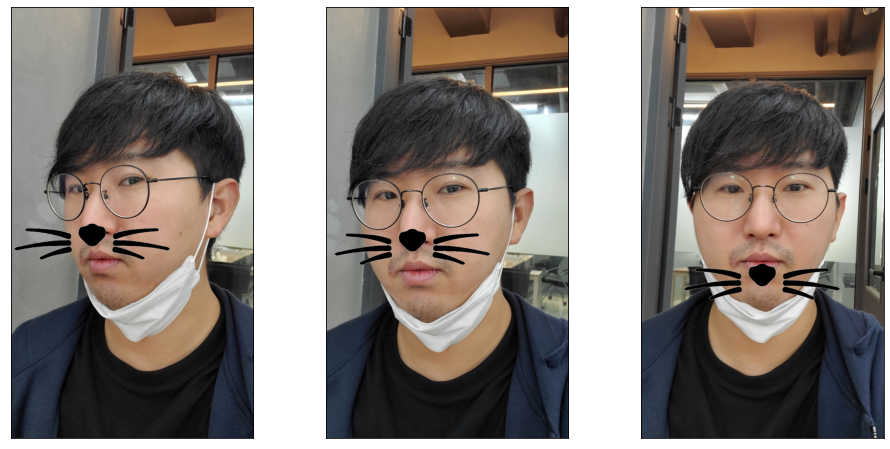

In [17]:
img_sticker = cv2.imread(STICKER_PATH) # 스티커 이미지
show_result_img_list = [i.copy() for i in img_rgb_list] # 최종 표시

for dlib_rects, points, img_show in zip(dlib_rects_list, landmark_gtx_points_list, show_result_img_list):  # 이미지와 찾은 얼굴 영역의 좌표
    rect = dlib_rects[0] # 찾은 얼굴 영역의 좌표
    w = h = rect.height()
    print(w) 
    img_sticker_re = cv2.resize(img_sticker, (w,h)) # 가로를 기준으로 스티커 리사이즈

    # 코끝이 기준점
    x = points[29][0]
    y = points[29][0]

    print(points[30])

    # 이미지 출력 시작좌표
    refined_x = x - (w // 2)
    refined_y = y + (w // 2)

    if refined_x < 0: 
        img_sticker_re = img_sticker_re[:, -refined_x:]
        refined_x = 0
    if refined_y < 0:
        img_sticker_re = img_sticker_re[-refined_y:, :]
        refined_y = 0

    # 이미지 적용
    sticker_area = img_show[refined_y:refined_y+img_sticker_re.shape[0], refined_x:refined_x+img_sticker_re.shape[1]]
    img_show[
        refined_y:refined_y+img_sticker_re.shape[0]
        , refined_x:refined_x+img_sticker_re.shape[1]
    ] = np.where(img_sticker_re==255,sticker_area,img_sticker_re).astype(np.uint8)

fig = plt.figure(figsize=(16,27))
for idx, i in enumerate(show_result_img_list, 1):
    ax = fig.add_subplot(330 + idx).imshow(i)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
plt.show()


### 회고

- 모델의 ㅅ

### 실패한 시도(얼굴의 각도 대응)

In [16]:
# 3D 모델이 없을 시 기본으로 설정하는 값
model_points = np.array([
                            (0.0, 0.0, 0.0),             # Nose tip
                            (0.0, -330.0, -65.0),        # Chin
                            (-225.0, 170.0, -135.0),     # Left eye left corner
                            (225.0, 170.0, -135.0),      # Right eye right corne
                            (-150.0, -150.0, -125.0),    # Left Mouth corner
                            (150.0, -150.0, -125.0)      # Right mouth corner
                        ])

for rect, img in zip(dlib_cnn_rects_list,img_rgb_list):
    # Camera internals
    size = img.shape
    focal_length = size[1]
    center = (size[1]/2, size[0]/2)
    camera_matrix = np.array(
                            [[focal_length, 0, center[0]],
                            [0, focal_length, center[1]],
                            [0, 0, 1]], dtype = "double"
                            )

    img_rect = rect[0].rect
    face_img = img[img_rect.top(): img_rect.bottom(),
            img_rect.left(): img_rect.right()]
    face_img = cv2.resize(face_img, (128, 128))
    print(keras.models.load_model(ANGLE_MODEL))

    predictions = keras.models.load_model(ANGLE_MODEL).model.signatures["predict"](
        tf.constant([face_img], dtype=tf.uint8))

    # Convert predictions to landmarks.
    marks = np.array(predictions['output']).flatten()[:136]
    marks = np.reshape(marks, (-1, 2))

    marks *= (img_rect[2] - img_rect[0])
    marks[:, 0] += img_rect[0]
    marks[:, 1] += img_rect[1]
    shape = marks.astype(np.uint)
    # mark_detector.draw_marks(img, marks, color=(0, 255, 0))
    image_points = np.array([
                            shape[30],     # Nose tip
                            shape[8],     # Chin
                            shape[36],     # Left eye left corner
                            shape[45],     # Right eye right corne
                            shape[48],     # Left Mouth corner
                            shape[54]      # Right mouth corner
                        ], dtype="double")
    dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
    (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_UPNP)

    # Project a 3D point (0, 0, 1000.0) onto the image plane.
    # We use this to draw a line sticking out of the nose

    (nose_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)
    p1 = ( int(image_points[0][0]), int(image_points[0][1]))
    p2 = ( int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))

    try:
        m = (p2[1] - p1[1])/(p2[0] - p1[0])
        ang = int(math.degrees(math.atan(m)))
    except:
        ang = 90

OSError: ignored

2차원의 이미지를 3차원 모델로 만든 후, 얼굴 윤곽의 점과 코 끝위치로 회전한 각도를 구하는 코드이다.<br>
하지만 미리 학습된 모델이 karas라이브러리에서 더이상 지원하지 않는 포멧이여서
더이상 진행할 수가 없었다.<br>
아래의 링크를 참조하였다.<br>
https://towardsdatascience.com/real-time-head-pose-estimation-in-python-e52db1bc606a